# Hardware Initialization and Configuration

This section initializes the FPGA hardware by loading the overlay bitstream and connecting to the matrix multiplication accelerator IP. The code configures the PL (Programmable Logic) clock and displays the available IP cores and register map of the accelerator.

Key components:
- Loads the FPGA bitstream for the systolic array matrix multiplier
- Displays the current PL clock frequency (100MHz)
- Enumerates available IP blocks in the design
- Maps the register interface of the matrix multiplication accelerator for control and data exchanges

In [4]:
from pynq import Overlay
from pynq import Clocks

overlay = Overlay("/home/ubuntu/workspace/pynq_bitfiles/2-26/MatMul_SA9.bit")
overlay.download()
print(f"current IP PL clock hz: {Clocks.fclk0_mhz}Mhz")

print(overlay.ip_dict.keys())
accel_ip = overlay.mmult_accel_0
print(accel_ip.register_map)

current IP PL clock hz: 99.999Mhz
dict_keys(['mmult_accel_0', 'zynq_ultra_ps_e_0'])
RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  A_1 = Register(A=write-only),
  A_2 = Register(A=write-only),
  B_1 = Register(B=write-only),
  B_2 = Register(B=write-only),
  C_1 = Register(C=write-only),
  C_2 = Register(C=write-only),
  N = Register(N=write-only),
  K = Register(K=write-only),
  M = Register(M=write-only),
  update_A = Register(update_A=write-only)
}


# Core Functions and Utilities

This section implements the core functionality required for FPGA-CPU interaction and performance measurement. It defines functions for matrix multiplication execution and energy measurement.

Key components:
- `call_fpga()`: Handles memory management and parameter configuration for the hardware accelerator
- `read_power()`: Reads system power consumption from the hardware power monitor
- `measure_energy()`: Measures energy consumption during function execution
- Implements proper memory synchronization between CPU and FPGA using flush/invalidate operations
- Supports persistent weight storage optimization via the `update_A` parameter

In [5]:
import numpy as np
import torch
from pynq import allocate

def call_fpga(A_buf, B_buf, C_buf, accel_ip, N, K, M, update_A):
    """
    Runs a 2D matrix multiplication on the FPGA accelerator:
      (N, K) x (K, M) => (N, M)

    A_buf, B_buf, C_buf are PYNQ buffers allocated with shape=(N,K), (K,M), (N,M).
    update_A: 1 to load A into BRAM (new input), 0 to reuse persistent A.
    """
    print("calling fpga, update_A =", update_A)
    
    # Flush input buffers to ensure data consistency.
    # Only flush A_buf if we intend to update A (update_A==1).
    if update_A:
        A_buf.flush()
    B_buf.flush()

    # Configure the accelerator registers
    accel_ip.register_map.A_1 = A_buf.physical_address & 0xFFFFFFFF
    accel_ip.register_map.A_2 = (A_buf.physical_address >> 32) & 0xFFFFFFFF
    accel_ip.register_map.B_1 = B_buf.physical_address & 0xFFFFFFFF
    accel_ip.register_map.B_2 = (B_buf.physical_address >> 32) & 0xFFFFFFFF
    accel_ip.register_map.C_1 = C_buf.physical_address & 0xFFFFFFFF
    accel_ip.register_map.C_2 = (C_buf.physical_address >> 32) & 0xFFFFFFFF
    accel_ip.register_map.N = N
    accel_ip.register_map.K = K
    accel_ip.register_map.M = M
    # Pass the update_A flag to the accelerator
    accel_ip.register_map.update_A = update_A

    # Start the accelerator
    accel_ip.register_map.CTRL.AP_START = 1

    # Wait for finish
    while accel_ip.register_map.CTRL.AP_DONE == 0:
        pass

    # Invalidate output buffer so the CPU sees the updated data from DDR
    C_buf.invalidate()
    
def read_power():
    """Reads power from hwmon2 (returns in Watts)"""
    try:
        with open("/sys/class/hwmon/hwmon2/power1_input", "r") as f:
            power_microwatts = int(f.read().strip())  # Read power in µW
            return power_microwatts / 1e6  # Convert to Watts
    except FileNotFoundError:
        print("Power sensor not found")
        return None
    
def measure_energy(func, *args):
    """Measures total energy used by `func` in Joules"""
    power_samples = []
    timestamps = []

    start_time = time.time()

    # Run the function while sampling power
    result = func(*args)  # Execute the computation

    active_power = read_power()  # Measure power after running workload
    elapsed_time = time.time() - start_time  # Compute execution time

    avg_power = active_power  # Since we measure before & after execution
    energy_used = avg_power * elapsed_time  # E = P × t

    return result, energy_used, avg_power  # Subtract idle power to isolate workload power

# Memory Allocation and Initialization

This section prepares the data structures needed for matrix multiplication benchmarking. It allocates physically contiguous memory buffers accessible by both the CPU and FPGA accelerator.

Key components:
- Defines matrix dimensions for the benchmark (N=64, K=768, M=3072)
- Allocates non-cacheable memory buffers for input matrices A and B and output matrix C
- Initializes input matrices with random int8 values to simulate quantized neural network operations
- Ensures data consistency by flushing CPU caches to main memory

In [13]:
# 2) Prepare Buffers (Using a small example for demonstration)
# Suppose we want to multiply a [N, K] x [K, M] => [N, M]
# DistilBERT typical Q/K/V matmul: shape [batch*seq_len, 768] x [768, 768]
# For demonstration, let’s do a small random size. We’ll adapt logic for DistilBERT below.
N, K, M = 64, 768, 3072
A_buf = allocate(shape=(N, K), dtype=np.int8, cacheable=False)
B_buf = allocate(shape=(K, M), dtype=np.int8, cacheable=False)
C_buf = allocate(shape=(N, M), dtype=np.int32, cacheable=False) # accelerator writes int32 results

# 3) Initialize Input Data (simulate random int8 values)
A_buf[:] = np.random.randint(-128, 127, size=(N,K), dtype=np.int8)
B_buf[:] = np.random.randint(-128, 127, size=(K,M), dtype=np.int8)
# A_buf[:] = np.zeros((N, K), dtype=np.int8)
# B_buf[:] = np.zeros((K, M), dtype=np.int8)

# flush caches so data is in DDR
A_buf.flush()
B_buf.flush()

# FPGA Accelerator Benchmark

This section executes and measures the performance of the FPGA-based matrix multiplication accelerator. It captures detailed timing and power metrics for the hardware implementation.

Key components:
- Separates data transfer time from computation time for accurate performance analysis
- Measures system power during accelerator execution
- Records energy consumption for the complete hardware pipeline
- Implements proper memory transfer protocol (flush before compute, invalidate after compute)
- Demonstrates the use of the `measure_energy()` function to capture power efficiency metrics

In [14]:
import time

# ============================================
# 🚀 Step 3: BENCHMARK - FPGA ACCELERATOR
# ============================================

# FPGA Execution
start_data_in = time.time()
A_buf.flush()
B_buf.flush()
end_data_in = time.time()

start_power_fpga = read_power()
start_fpga = time.time()
_,fpga_energy, fpga_power = measure_energy(lambda: call_fpga(A_buf, B_buf, C_buf, accel_ip, N, K, M, update_A=1))
end_fpga = time.time()
end_power_fpga = read_power()

start_data_out = time.time()
C_buf.invalidate()
result_fpga = C_buf[:, :].copy()
end_data_out = time.time()

print(f"FPGA Energy: {fpga_energy:.6f} J, Average system power: {fpga_power:.3f} W")

calling fpga, update_A = 1
FPGA Energy: 0.333922 J, Average system power: 3.490 W


# CPU Reference Implementations

This section benchmarks CPU-based matrix multiplication using NumPy and PyTorch libraries as reference implementations. These measurements establish the baseline for evaluating FPGA acceleration benefits.

Key components:
- Implements NumPy integer matrix multiplication as a reference benchmark
- Implements PyTorch tensor-based matrix multiplication as a modern optimized baseline
- Measures execution time and energy consumption for both CPU implementations
- Enables direct comparison between FPGA and CPU approaches under identical workloads

In [17]:
# ===========================
# 💻 Step 4: CPU REFERENCE (NumPy & PyTorch)
# ===========================
start_cpu_numpy = time.time()
ref_numpy, numpy_energy, numpy_power = measure_energy(lambda: np.matmul(A_buf.astype(np.int32), B_buf.astype(np.int32)))
ref_numpy = -1
end_cpu_numpy = time.time()

start_cpu_torch = time.time()
device = torch.device("cpu")
ref_torch, torch_energy, torch_power = measure_energy(
    lambda: torch.matmul(torch.tensor(A_buf.astype(np.int32)), torch.tensor(B_buf.astype(np.int32)))
)
ref_torch_np = ref_torch.cpu().numpy()
end_cpu_torch = time.time()

print(f"NumPy CPU Energy: {numpy_energy:.6f} J, Average system power: {numpy_power:.3f} W")
print(f"PyTorch CPU Energy: {torch_energy:.6f} J, Average system power: {torch_power:.3f} W")

NumPy CPU Energy: 70.490563 J, Average system power: 3.380 W
PyTorch CPU Energy: 1.350050 J, Average system power: 3.440 W


# Result Verification and Accuracy Analysis

This section verifies the correctness of the FPGA implementation by comparing its output against CPU reference implementations. It also calculates key performance metrics for comparison.

Key components:
- Validates accelerator results against NumPy and PyTorch reference implementations
- Computes maximum error between hardware and software outputs
- Calculates total operations (multiply-accumulate) performed in the matrix multiplication
- Computes throughput metrics (operations per second) for all implementations
- Prepares speedup metrics comparing the FPGA against CPU implementations

In [18]:
# ============================
# 🧪 Step 5: ACCURACY CHECK
# ============================
diff_numpy = np.abs(ref_numpy - result_fpga)
max_err_numpy = np.max(diff_numpy)

diff_torch = np.abs(ref_torch_np - result_fpga)
max_err_torch = np.max(diff_torch)

# ============================
# 📊 Step 6: PERFORMANCE METRICS
# ============================
total_ops = 2 * N * K * M

acc_latency = end_fpga - start_fpga
total_hw_time = end_data_out - start_data_in
hw_throughput = (total_ops / acc_latency) / 1e9
hw_end_to_end = (total_ops / total_hw_time) / 1e9

sw_time_numpy = end_cpu_numpy - start_cpu_numpy
sw_throughput_numpy = (total_ops / sw_time_numpy) / 1e9
speedup_latency_numpy = sw_time_numpy / acc_latency
speedup_total_numpy = sw_time_numpy / total_hw_time

sw_time_torch = end_cpu_torch - start_cpu_torch
sw_throughput_torch = (total_ops / sw_time_torch) / 1e9
speedup_latency_torch = sw_time_torch / acc_latency
speedup_total_torch = sw_time_torch / total_hw_time

print(result_fpga)
print(ref_torch_np)

[[-238544   85120   71542 ...   10970 -243562 -340368]
 [ 111855 -177407  305892 ...   -2240  -87531   -2269]
 [-220887 -221108  -76009 ... -100878  256056  118634]
 ...
 [-339509  105559 -145198 ...    9566  -74882  142282]
 [  92963  -19708  -27047 ...   60135   27024  144517]
 [ -56316 -124743  142942 ...   22040  126140  162291]]
[[-238544   85120   71542 ...   10970 -243562 -340368]
 [ 111855 -177407  305892 ...   -2240  -87531   -2269]
 [-220887 -221108  -76009 ... -100878  256056  118634]
 ...
 [-339509  105559 -145198 ...    9566  -74882  142282]
 [  92963  -19708  -27047 ...   60135   27024  144517]
 [ -56316 -124743  142942 ...   22040  126140  162291]]


# Performance Visualization and Analysis

This section presents comprehensive performance metrics and creates visualizations comparing the different implementations. The results highlight the advantages of the FPGA-based accelerator.

Key components:
- Displays formatted performance summary with emoji indicators for readability
- Shows latency, throughput, and energy consumption metrics for all implementations
- Calculates and displays speedup factors between FPGA and CPU implementations
- Creates publication-quality bar charts comparing:
  - Execution time (lower is better)
  - Computational throughput (higher is better)
  - Energy consumption (lower is better)
- Uses logarithmic scale to properly visualize wide-ranging performance differences


🎯 Performance Comparison
🔢 MatMul Shape: [64 , 768] x [768 , 3072]
❌ Max difference (NumPy vs FPGA): 765037
✅ Max difference (PyTorch vs FPGA): 0

📊 Latency & Throughput
🧮 NumPy  : ⏱️ 20.856134 sec |  ⚡ 0.01 GFLOPs
🔥 PyTorch: ⏱️ 0.393857 sec  |  ⚡ 0.77 GFLOPs
🚀 FPGA   : ⏱️ 0.096494 sec  |  ⚡ 3.13 GFLOPs

⏱️ Total HW Time : ⏱️ 0.107257 sec  |  ⚡ 2.82 GFLOPs

FPGA Speedup vs NumPy   : 216.14x (Latency) | 194.45x (Total) 🚀🚀🚀
FPGA Speedup vs PyTorch :   4.08x (Latency) | 3.67x (Total) 🚀

✅ Test Completed! 🎯


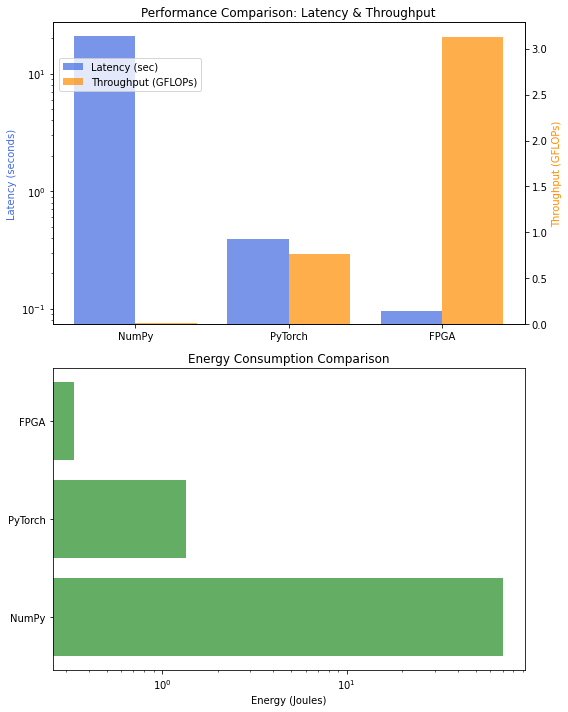

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Determine emoji for accuracy check
diff_numpy_emoji = "❌" if max_err_numpy != 0 else "✅"
diff_torch_emoji = "❌" if max_err_torch != 0 else "✅"

# Define speedup emoji function
def speedup_emoji(speedup):
    if speedup >= 25:
        return "🚀🚀🚀"
    elif speedup >= 10:
        return "🚀🚀"
    elif speedup >= 1:
        return "🚀"
    return "🐢"

# ================================
# 🎯 Step 7: PERFORMANCE SUMMARY
# ================================
print("\n🎯 Performance Comparison")
print(f"🔢 MatMul Shape: [{N} , {K}] x [{K} , {M}]")

print(f"{diff_numpy_emoji} Max difference (NumPy vs FPGA): {max_err_numpy}")
print(f"{diff_torch_emoji} Max difference (PyTorch vs FPGA): {max_err_torch}\n")

print("📊 Latency & Throughput")
print(f"🧮 NumPy  : ⏱️ {sw_time_numpy:.6f} sec |  ⚡ {sw_throughput_numpy:.2f} GFLOPs")
print(f"🔥 PyTorch: ⏱️ {sw_time_torch:.6f} sec  |  ⚡ {sw_throughput_torch:.2f} GFLOPs")
print(f"🚀 FPGA   : ⏱️ {acc_latency:.6f} sec  |  ⚡ {hw_throughput:.2f} GFLOPs\n")

print(f"⏱️ Total HW Time : ⏱️ {total_hw_time:.6f} sec  |  ⚡ {hw_end_to_end:.2f} GFLOPs\n")

print(f"FPGA Speedup vs NumPy   : {speedup_latency_numpy:.2f}x (Latency) | {speedup_total_numpy:.2f}x (Total) {speedup_emoji(speedup_latency_numpy)}")
print(f"FPGA Speedup vs PyTorch :   {speedup_latency_torch:.2f}x (Latency) | {speedup_total_torch:.2f}x (Total) {speedup_emoji(speedup_latency_torch)}")

print("\n✅ Test Completed! 🎯")

# ================================
# 📊 Visualization
# ================================

# Data for plotting
frameworks = ["NumPy", "PyTorch", "FPGA"]
latencies = [sw_time_numpy, sw_time_torch, acc_latency]  # Lower is better
throughputs = [sw_throughput_numpy, sw_throughput_torch, hw_throughput]  # Higher is better
energies = [numpy_energy, torch_energy, fpga_energy]  # Energy in Joules

x = np.arange(len(frameworks))  # X-axis positions

# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Bar width
bar_width = 0.4

# Plot latency & throughput (first subplot)
ax1.bar(x - bar_width / 2, latencies, width=bar_width, label="Latency (sec)", color='royalblue', alpha=0.7)
ax1.set_ylabel("Latency (seconds)", color='royalblue')
ax1.set_yscale("log")  # Log scale for better visualization

ax3 = ax1.twinx()
ax3.bar(x + bar_width / 2, throughputs, width=bar_width, label="Throughput (GFLOPs)", color='darkorange', alpha=0.7)
ax3.set_ylabel("Throughput (GFLOPs)", color='darkorange')

ax1.set_xticks(x)
ax1.set_xticklabels(frameworks)
ax1.set_title("Performance Comparison: Latency & Throughput")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.92))

# Plot energy consumption (second subplot)
ax2.barh(x, energies, color='forestgreen', alpha=0.7)  # Thinner bars
ax2.set_xlabel("Energy (Joules)")
ax2.set_yticks(x)
ax2.set_yticklabels(frameworks)
ax2.set_title("Energy Consumption Comparison")
ax2.set_xscale("log")  # Apply log scale to energy axis

# Adjust layout and show plot
plt.tight_layout()
plt.show()